# NTS Data




In [1]:
import random

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from caveat.evaluate.describe import features
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot
from caveat.evaluate.distance import mape, emd
from caveat.evaluate.features import participation, times

In [184]:
attributes = pd.read_csv("C:/Users/ucfnfjs/Data/2022_nts_home/attributes.csv")
schedules = pd.read_csv("C:/Users/ucfnfjs/Data/2022_nts_home/schedules.csv")


def age_group(age):
    if age < 17:
        return "child"
    elif age < 30:
        return "young adult"
    elif age < 65:
        return "adult"
    else:
        return "senior"


def fix_ethnicity(x):
    if x == "unknown":
        return "white"
    return x


def fix_car_access(x):
    if x == "unknown":
        return "yes"
    return x


def fix_children(x):
    if x > 2:
        return "3+"
    return str(x)


income_groups = {1: "lowest", 2: "low", 3: "medium", 4: "high", 5: "highest"}
work_groups = {
    "FT": "FT",
    "PT": "PT",
    "retired": "retired",
    "unknown": "other",
    "other": "other",
    "student": "other",
    "unemployed": "other",
}

attributes["age_group"] = attributes["age"].apply(age_group)
attributes["income_group"] = attributes["income"].apply(
    lambda x: income_groups[x]
)
attributes["ethnicity"] = attributes["ethnicity"].apply(fix_ethnicity)
attributes["work_status"] = attributes["work_status"].map(work_groups)
attributes["car_access"] = attributes["car_access"].apply(fix_car_access)
attributes["hh_children"] = attributes["hh_children"].apply(fix_children)

In [185]:
attributes.hh_children.value_counts()

hh_children
0     24215
2      7344
1      6150
3+     2141
Name: count, dtype: int64

In [186]:
def filter_on(attributes, schedules, on, minimum=1000):
    values = attributes[on].value_counts()
    print(values)
    selected = {}
    for value in values.index:
        pids = attributes[attributes[on] == value]["pid"]
        if len(pids) < minimum:
            selected[value] = pd.DataFrame()
        else:
            selected[value] = schedules[schedules["pid"].isin(pids)]
    return selected


def build_table(schedules, filters, op):
    participation_rates = {"all": op(schedules)}
    for filter in filters:
        for key, value in filter.items():
            participation_rates[key] = op(value)

    return pd.DataFrame(participation_rates)


gender_filtered = filter_on(attributes, schedules, "gender")
age_filtered = filter_on(attributes, schedules, "age_group")
age_filtered = {
    i: age_filtered[i] for i in ["senior", "adult", "young adult", "child"]
}
ethnicity_filtered = filter_on(attributes, schedules, "ethnicity")
education_filtered = filter_on(attributes, schedules, "education")
license_filtered = filter_on(attributes, schedules, "license")
car_access_filtered = filter_on(attributes, schedules, "car_access")
work_filtered = filter_on(attributes, schedules, "work_status")
area_filtered = filter_on(attributes, schedules, "area")
income_filtered = filter_on(attributes, schedules, "income_group")
income_filtered = {
    i: income_filtered[i]
    for i in ["highest", "high", "medium", "low", "lowest"]
}
hh_filtered = filter_on(attributes, schedules, "hh_composition")
children_filtered = filter_on(attributes, schedules, "hh_children")
children_filtered = {i: children_filtered[i] for i in ["0", "1", "2", "3+"]}

gender
F    20185
M    19665
Name: count, dtype: int64
age_group
adult          20071
senior          8535
child           6765
young adult     4479
Name: count, dtype: int64
ethnicity
white        35720
non-white     4130
Name: count, dtype: int64
education
Y          29535
unknown     6491
N           3824
Name: count, dtype: int64
license
yes        29884
unknown     6463
no          3503
Name: count, dtype: int64
car_access
yes    35929
no      3921
Name: count, dtype: int64
work_status
FT         16453
other       9325
retired     9256
PT          4816
Name: count, dtype: int64
area
urban       18024
suburban    13905
rural        7921
Name: count, dtype: int64
income_group
high       8859
highest    8734
medium     8608
low        7393
lowest     6256
Name: count, dtype: int64
hh_composition
2adults            11670
2adult_1+child     11292
3+adults            5978
1adult              4895
3+adult_1+child     2818
unknown             1672
single_parent       1525
Name: count, dty

In [187]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        work_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    #   car_access_filtered, work_filtered, area_filtered, income_filtered],
    lambda x: features.average(times.start_times_by_act(x)),
)

,all,F,M,senior,adult,young adult,child,Y,unknown,N,...,yes,no,urban,suburban,rural,highest,high,medium,low,lowest
education,0.363959,0.364824,0.362994,0.421875,0.421296,0.405283,0.358011,0.399014,0.356932,0.386926,...,0.409014,0.385005,0.363021,0.365959,0.361593,0.361146,0.363996,0.360244,0.365712,0.367865
escort,0.538507,0.536670,0.541043,0.548169,0.535175,0.548597,0.539951,0.539293,0.540118,0.526917,...,0.538647,0.522410,0.538338,0.540964,0.534424,0.542824,0.544253,0.538349,0.536872,0.529504
home,0.353960,0.352536,0.355454,0.326957,0.364372,0.371713,0.346229,0.358975,0.345399,0.328693,...,0.357429,0.337587,0.351804,0.358304,0.351353,0.360377,0.359829,0.355217,0.346584,0.343621
medical,0.506454,0.508720,0.503704,0.500615,0.507541,0.512847,0.542893,0.507433,0.540383,0.491700,...,0.505416,0.498795,0.505869,0.514545,0.496299,0.509997,0.516597,0.502005,0.503558,0.502367
other,0.548414,0.546963,0.549916,0.524719,0.560356,0.598318,0.527347,0.556125,0.524769,0.522572,...,0.551857,0.561346,0.548888,0.555823,0.536120,0.555887,0.550335,0.548111,0.543009,0.539748
shop,0.530057,0.528283,0.532218,0.498914,0.546681,0.568126,0.565232,0.535061,0.560747,0.499137,...,0.532009,0.509774,0.527076,0.537388,0.524916,0.550353,0.539387,0.525478,0.519269,0.516049
visit,0.560345,0.559443,0.561486,0.540781,0.570312,0.604572,0.539942,0.568449,0.538780,0.538526,...,0.565011,0.557639,0.553081,0.575383,0.550418,0.560297,0.559463,0.567408,0.556216,0.557975
work,0.379444,0.388692,0.371774,0.407036,0.377660,0.378988,0.473011,0.379396,0.398341,0.378015,...,0.377893,0.397905,0.374816,0.382787,0.384012,0.370690,0.377769,0.371977,0.387645,0.412185


In [188]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    lambda x: features.sd(times.start_times_by_act(x)),
)

,all,F,M,senior,adult,young adult,child,Y,unknown,N,yes,no,urban,suburban,rural,highest,high,medium,low,lowest
education,0.038493,0.040057,0.036647,0.043403,0.058320,0.071089,0.026551,0.071857,0.021290,0.063235,0.069097,0.070538,0.038170,0.042106,0.029785,0.034421,0.037987,0.034030,0.042274,0.041650
escort,0.159870,0.155204,0.166066,0.149609,0.166615,0.173441,0.137722,0.165823,0.136709,0.153475,0.164958,0.155688,0.160573,0.160428,0.157019,0.166347,0.166508,0.159321,0.152952,0.152369
home,0.334010,0.330489,0.337661,0.308726,0.337858,0.361772,0.334276,0.336308,0.333432,0.315441,0.333802,0.336187,0.331289,0.339536,0.330451,0.339064,0.339412,0.334099,0.328938,0.324421
medical,0.108873,0.109599,0.107922,0.098811,0.115947,0.111817,0.127300,0.110433,0.127482,0.091985,0.108957,0.096993,0.107419,0.112399,0.105806,0.118003,0.109720,0.106254,0.109895,0.100929
other,0.142002,0.139277,0.144754,0.122886,0.149066,0.146499,0.137677,0.143824,0.136630,0.126849,0.143431,0.132036,0.142029,0.142407,0.140493,0.146542,0.146772,0.139453,0.136525,0.136148
shop,0.118396,0.114540,0.122898,0.098971,0.125299,0.127083,0.112845,0.120826,0.113491,0.099129,0.119957,0.103583,0.118116,0.119205,0.117129,0.122041,0.120725,0.116793,0.113752,0.115204
visit,0.125570,0.122949,0.128803,0.115113,0.127514,0.137850,0.119803,0.127370,0.120441,0.114519,0.127232,0.112593,0.119812,0.130344,0.127019,0.124657,0.128672,0.129943,0.123506,0.119759
work,0.111947,0.108426,0.114219,0.121202,0.111623,0.109139,0.135857,0.109509,0.137541,0.138657,0.109736,0.134091,0.111559,0.114043,0.108671,0.095245,0.106010,0.113864,0.122218,0.134297


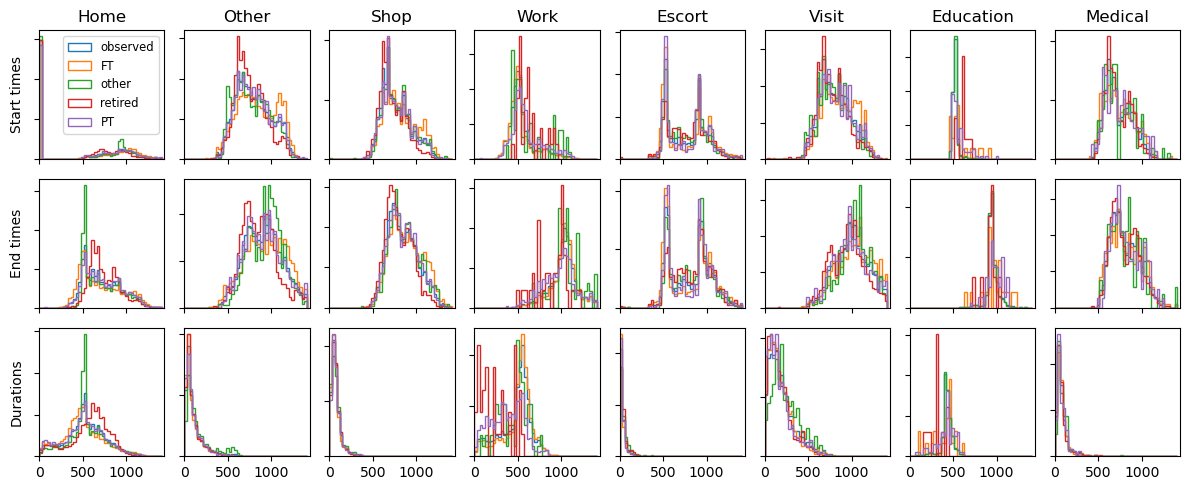

In [189]:
fig = times_distributions_plot(schedules, work_filtered)

acts:  {'medical', 'education', 'home', 'escort', 'other', 'work', 'visit', 'shop'}
dict_keys(['FT', 'other', 'retired', 'PT'])


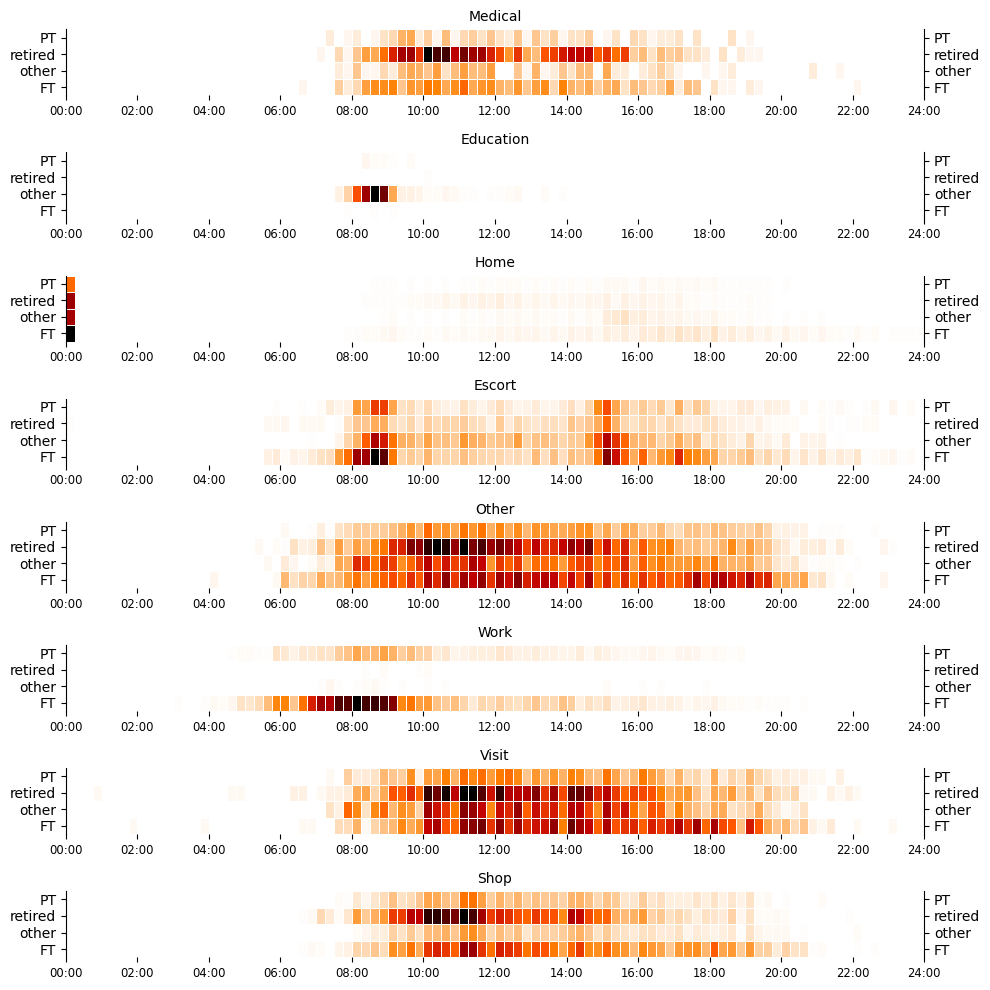

In [190]:
def plot_times(
    subs,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):

    if acts is None:
        acts = set()
        for data in subs.values():
            acts.update(set(data.act))

    print("acts: ", acts)

    splits = {
        k: extract_activities(v, column, minimum, maximum)
        for k, v in subs.items()
    }
    print(splits.keys())

    return plot_bins(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def extract_activities(schedules, column, minimum, maximum):
    data = schedules.copy()
    if minimum is not None:
        data = data[data[column] >= minimum]
    if maximum is not None:
        data = data[data[column] <= maximum]
    return pd.DataFrame(
        {
            "act": data.act,
            "start": (data.start).astype(int),
            "end": (data.end).astype(int),
            "duration": (data.duration).astype(int),
        }
    )


def plot_bins(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig, axs = plt.subplots(
        len(acts),
        figsize=(width, len(acts) * (len(splits) + 1) / 4),
        sharex=False,
    )
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for ax, act in zip(axs, acts):
        keys = list(splits.keys())
        n_keys = len(keys)
        binned = time_binner(splits, act, column, minimum, maximum)
        if normalise:
            binned = binned / binned.max()
        ax.pcolormesh(
            binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
        )
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )
        ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
        ax.yaxis.set_ticklabels(keys)
        ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
        ax.tick_params(right=True, labelright=True)
        for pos in ["top", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_title(act.title(), fontsize="medium", rotation=0)

    fig.tight_layout()
    return fig


def time_binner(splits, act, column, minimum, maximum):
    """Bin start and end times and durations, return freq table for X hour period, 15min intervals."""
    bins = list(range(minimum, maximum + 1, 15))
    # bins[-1] = 100 * 60
    start = f"{int(minimum/60):02}:00:00"
    periods = int((maximum - minimum) / 15)
    labels = pd.timedelta_range(start=start, periods=periods, freq="15min")
    binned = pd.DataFrame(
        index=pd.timedelta_range(start=start, periods=periods, freq="15min")
    )
    for key, data in splits.items():
        split = data[data.act == act]
        binned[key] = pd.cut(
            split[column], bins, labels=labels, right=False
        ).value_counts()

    return binned


fig = plot_times(
    work_filtered,
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

acts:  {'medical', 'education', 'home', 'escort', 'other', 'work', 'visit', 'shop'}
dict_keys(['0', '1', '2', '3+'])


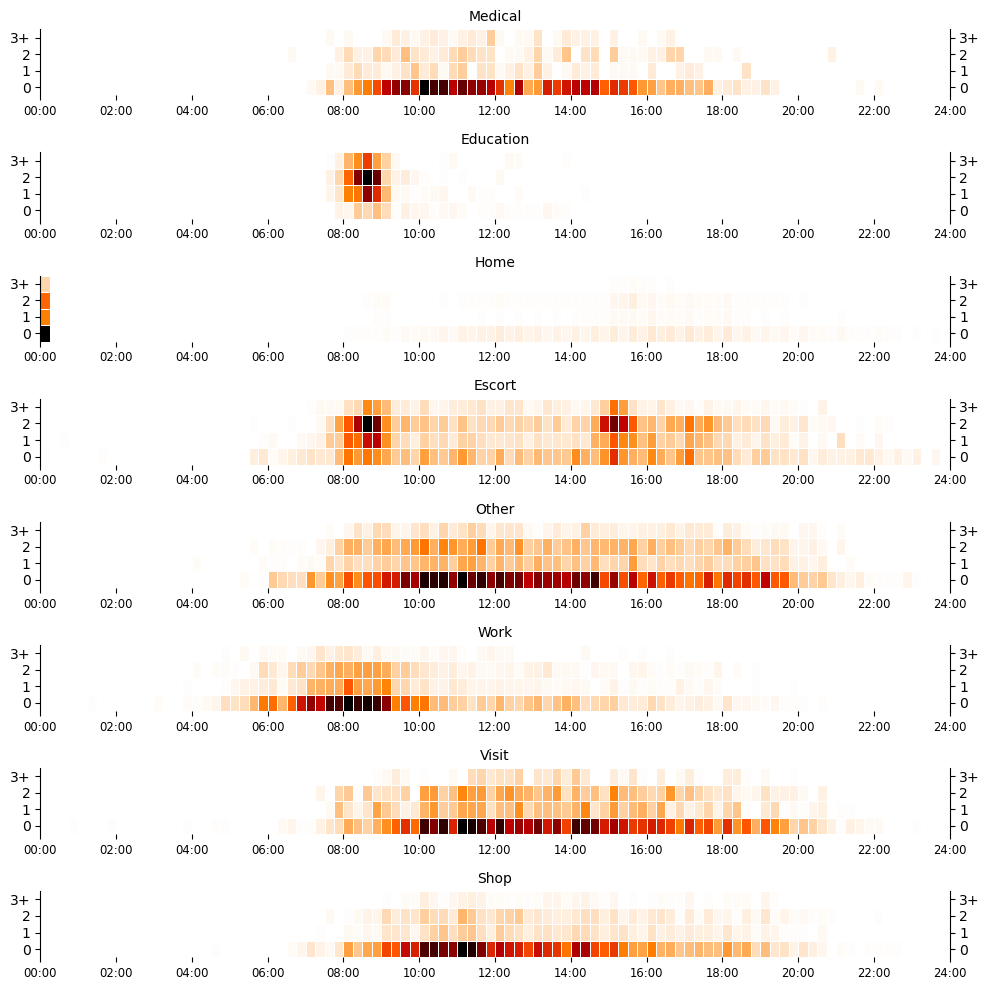

In [192]:
fig = plot_times(
    children_filtered,
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [9]:
op = lambda x: features.average(participation.participation_rates_by_act(x))

build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    op,
)

,all,F,M,adult,senior,child,young adult,Y,unknown,N,yes,no,urban,suburban,rural,high,highest,medium,low,lowest
education,0.075162,0.077843,0.072384,0.000956,0.000241,0.396516,0.081520,0.015121,0.391018,0.018940,0.008910,0.071579,0.066370,0.088981,0.071000,0.067846,0.055882,0.074285,0.076162,0.112618
escort,0.222055,0.253068,0.189912,0.275924,0.131458,0.250202,0.112528,0.220939,0.260003,0.166346,0.232839,0.063459,0.227807,0.221837,0.209538,0.194451,0.217413,0.213693,0.232788,0.266438
home,2.251193,2.265603,2.236257,2.310402,2.250724,2.134699,2.154039,2.280667,2.134729,2.216305,2.292466,2.110376,2.258586,2.238338,2.256827,2.251757,2.257642,2.258140,2.235083,2.250987
medical,0.038332,0.041291,0.035264,0.030652,0.084017,0.013067,0.019005,0.039590,0.013338,0.069448,0.041272,0.058045,0.038622,0.035084,0.043293,0.031500,0.029958,0.037266,0.046328,0.051674
other,0.460623,0.460315,0.460942,0.438695,0.577137,0.436845,0.359340,0.472410,0.441330,0.400769,0.475551,0.369023,0.478015,0.424782,0.483549,0.459656,0.515652,0.455862,0.435313,0.421631
shop,0.259020,0.279560,0.237731,0.266681,0.452680,0.037103,0.165791,0.288679,0.030897,0.405435,0.299202,0.326316,0.268212,0.246819,0.259491,0.240732,0.225361,0.251826,0.293316,0.301116
visit,0.119900,0.131616,0.107757,0.112516,0.146910,0.118890,0.100275,0.117868,0.119534,0.136152,0.123067,0.093835,0.117825,0.120827,0.122952,0.113400,0.107973,0.114770,0.129518,0.141459
work,0.254141,0.226365,0.282930,0.388918,0.051545,0.003549,0.427857,0.317406,0.003039,0.183640,0.311747,0.215338,0.253595,0.255918,0.252298,0.313545,0.261555,0.290331,0.223896,0.145579


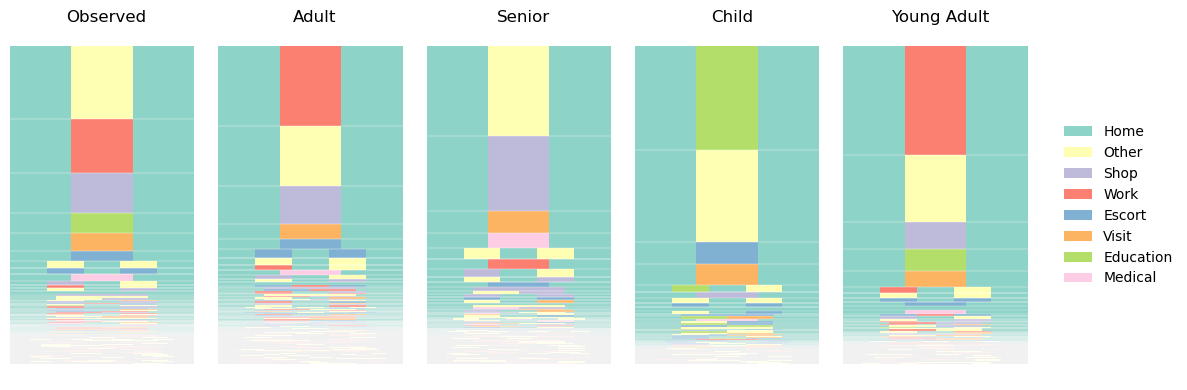

In [10]:
fig = sequence_prob_plot(schedules, age_filtered, figsize=(12, 4))

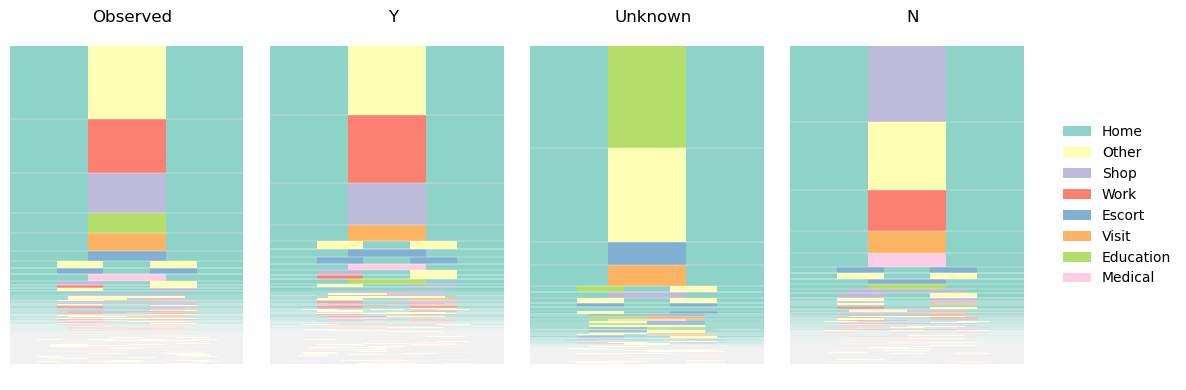

In [11]:
fig = sequence_prob_plot(schedules, education_filtered, figsize=(12, 4))

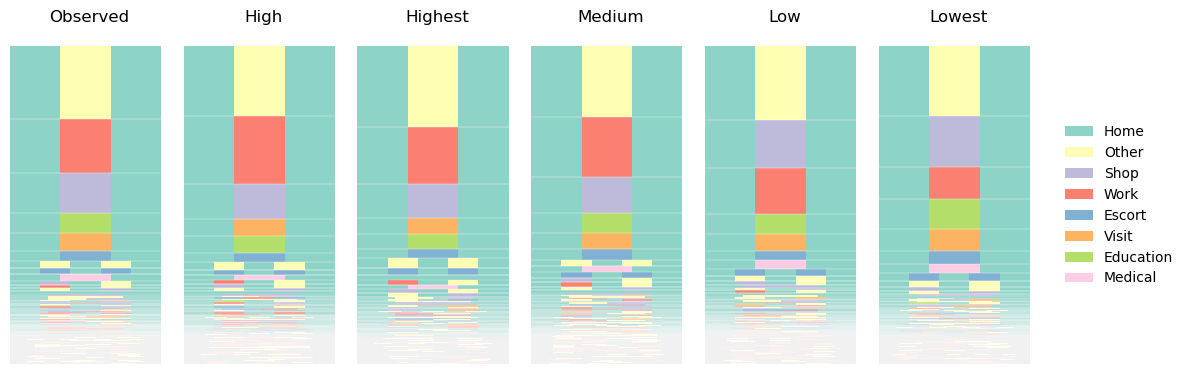

In [12]:
fig = sequence_prob_plot(schedules, income_filtered, figsize=(12, 4))

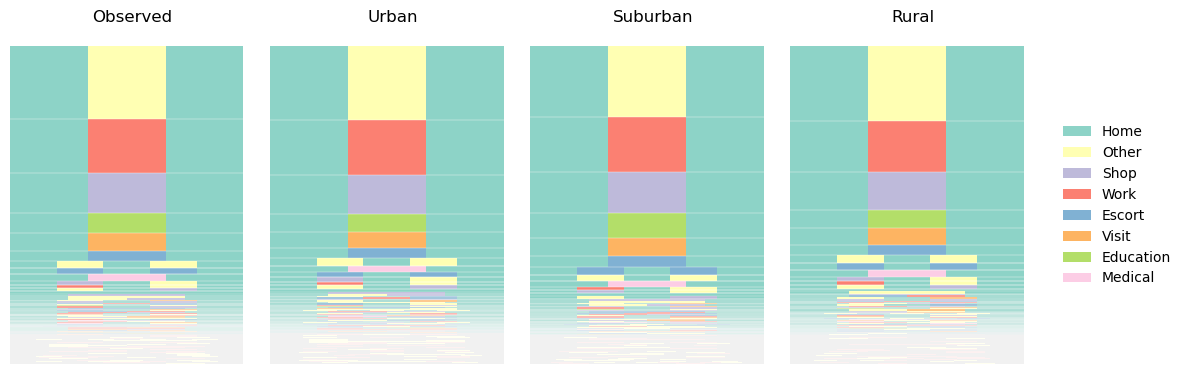

In [13]:
fig = sequence_prob_plot(schedules, area_filtered, figsize=(12, 4))

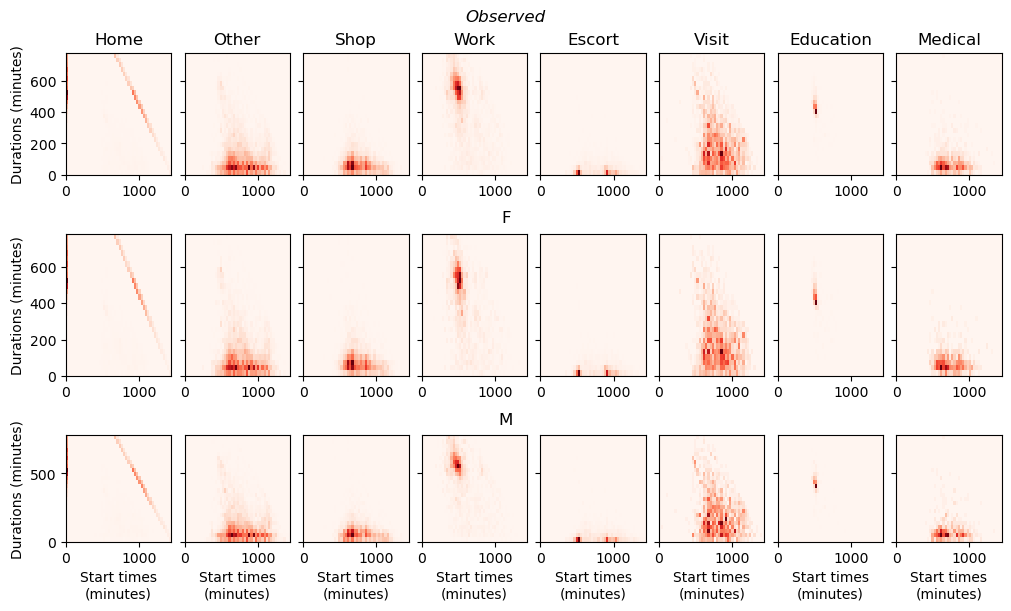

In [14]:
fig = joint_time_distributions_plot(schedules, gender_filtered, figsize=(10, 6))

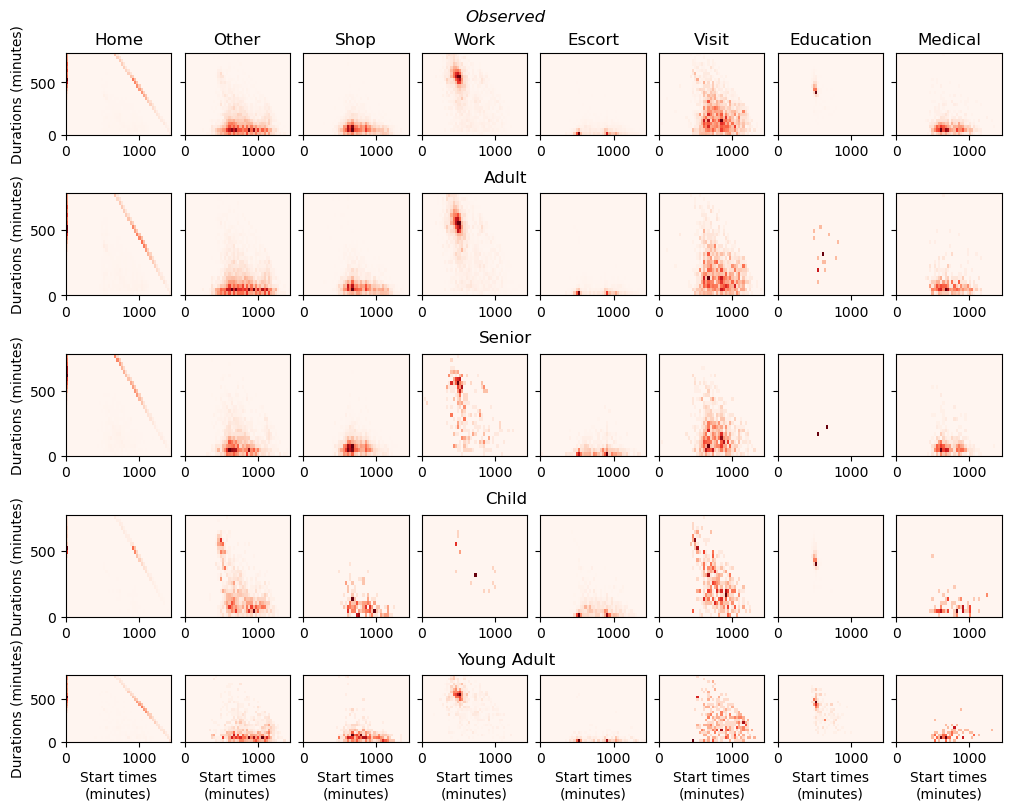

In [15]:
fig = joint_time_distributions_plot(schedules, age_filtered, figsize=(10, 8))